# State


In [1]:
from IPython.display import Image, display
import operator
from typing import List, Literal, TypedDict
from langgraph.graph import START, END, StateGraph
from langgraph.types import Command, interrupt

In [2]:
class State(TypedDict):
    nlist: List[str]

In [3]:
def node_a(state: State) -> State:
    print(f"This is from node a {state['nlist']}")
    note = "Hello World from node a"
    return (State(nlist=[note]))

In [4]:
builder = StateGraph(State)
builder.add_node("a", node_a)
builder.add_edge(START, "a")
builder.add_edge("a", END)
graph = builder.compile()


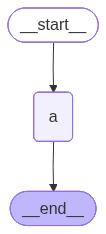

In [5]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
intial_a = State(
    nlist= "Hello node A"
)
graph.invoke(intial_a)

This is from node a Hello node A


{'nlist': ['Hello World from node a']}

# Static Edge

In [7]:
from IPython.display import Image, display
import operator
from typing import List, Literal, TypedDict
from langgraph.graph import START, END, StateGraph
from langgraph.types import Command, interrupt

In [8]:
class EmailState(dict):
    user_email: str
    intent: str
    reply: str

In [9]:
def classify_intent(state: EmailState):
    email = state['user_email']
    if "refund" in email.lower():
        intent = "refund_request"
    elif "delay" in email.lower():
        intent = "shipping_delay"
    else:
        intent = "general_question"
    return {"intent": intent}

In [10]:
def generate_reply(state: EmailState):
    intent = state["intent"]
    responses = {
        "refund_request": "I'm sorry to hear that. We will process your refund shortly.",
        "shipping_delay" : "Thanks for your patience — your package is on the way.",
        "general_question" : "Thanks for reaching out — we will get back to you shortly!"
    }
    reply = responses[intent]
    return {"reply": reply}

In [30]:
def log_and_finish(state: EmailState):
    print("📩 Intent:", state["intent"])
    print("💬 Reply:", state["reply"])
    return {}

In [31]:
builder = StateGraph(EmailState)

In [32]:
builder.add_node("classify", classify_intent)
builder.add_node("gen_reply", generate_reply)
builder.add_node("logger", log_and_finish)

In [33]:
builder.set_entry_point("classify")
builder.add_edge("classify", "gen_reply")
builder.add_edge("gen_reply", "logger")
builder.add_edge("logger", END)

In [34]:
graph = builder.compile()

In [35]:
result = graph.invoke({"user_email": "Hi, my order is delayed!"})
print(result)

📩 Intent: shipping_delay
💬 Reply: Thanks for your patience — your package is on the way.
{'user_email': 'Hi, my order is delayed!', 'intent': 'shipping_delay', 'reply': 'Thanks for your patience — your package is on the way.'}


In [36]:
result = graph.invoke({"user_email": "Hi, Where is my order?"})
print(result)

📩 Intent: general_question
💬 Reply: Thanks for reaching out — we will get back to you shortly!
{'user_email': 'Hi, Where is my order?', 'intent': 'general_question', 'reply': 'Thanks for reaching out — we will get back to you shortly!'}


In [37]:
result = graph.invoke({"user_email": "Hi, my refund request status"})
print(result)

📩 Intent: refund_request
💬 Reply: I'm sorry to hear that. We will process your refund shortly.
{'user_email': 'Hi, my refund request status', 'intent': 'refund_request', 'reply': "I'm sorry to hear that. We will process your refund shortly."}


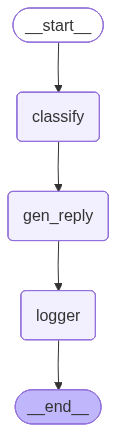

In [38]:
display(Image(graph.get_graph().draw_mermaid_png()))

# Dynamic Edge

In [13]:
from langgraph.graph import StateGraph, END

# ----- State -----
class EmailState(dict):
    user_email: str
    intent: str
    reply: str

# ----- Classifier Node -----
def classify(state: EmailState):
    email = state["user_email"].lower()

    if "refund" in email:
        intent = "refund"
    elif "delay" in email:
        intent = "delay"
    else:
        intent = "general"

    return {"intent": intent}

# ----- Branch Handlers -----
def refund_handler(state: EmailState):
    return {"reply": "Refund request acknowledged. Processing now."}

def delay_handler(state: EmailState):
    return {"reply": "We apologize — your shipment is delayed."}

def general_handler(state: EmailState):
    return {"reply": "Thanks for contacting support!"}

# ----- Finisher -----
def finish(state: EmailState):
    print(f"Intent: {state['intent']}")
    print(f"Reply:  {state['reply']}")
    return {}

# ----- Graph -----
workflow = StateGraph(EmailState)

workflow.add_node("classify", classify)
workflow.add_node("refund", refund_handler)
workflow.add_node("delay", delay_handler)
workflow.add_node("general", general_handler)
workflow.add_node("finish", finish)

workflow.set_entry_point("classify")

# ----- Conditional Routing -----
def route(state: EmailState):
    return state["intent"]   # must match keys below exactly

workflow.add_conditional_edges(
    "classify",
    route,
    {
        "refund": "refund",
        "delay": "delay",
        "general": "general"
    }
)

workflow.add_edge("refund", "finish")
workflow.add_edge("delay", "finish")
workflow.add_edge("general", "finish")
workflow.add_edge("finish", END)

graph = workflow.compile()

# ----- Test -----
result = graph.invoke({"user_email": "Hi, I want a refund for my order"})
print(result)


Intent: refund
Reply:  Refund request acknowledged. Processing now.
{'user_email': 'Hi, I want a refund for my order', 'intent': 'refund', 'reply': 'Refund request acknowledged. Processing now.'}


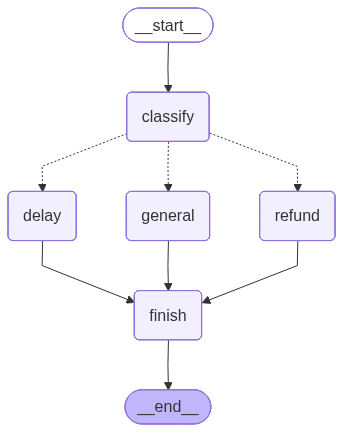

In [16]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

# Interrupt and Human-In-Loop

In [26]:
#-------- State Schema ---------------
from typing import Dict
from langgraph.graph import StateGraph, END

class EmailState(dict):
    user_email: str
    intent: str
    urgency: str
    reply: str


In [27]:
# ------------- LLM classifier Node -------------
from openai import OpenAI
llm = OpenAI()

def classify_email(state: EmailState):
    email = state["user_email"]

    prompt = f"""
    Classify this customer email into:
    Intent: one of ["question","bug","billing","feature","complex"]
    Urgency: one of ["low","medium","high","critical"]

    Email: \"\"\"{email}\"\"\"

    Provide JSON only:

    {{"intent": "...", "urgency": "..."}}
    """

    res = llm.chat.completions.create(
        model="gpt-5-mini",
        messages=[{"role":"user", "content":prompt}]
    )

    data = res.choices[0].message.content.strip()

    # convert LLM output string into dict
    result = eval(data)  # ✅ safe because we control prompt structure

    return {
        "intent": result["intent"],
        "urgency": result["urgency"]
    }


In [28]:
# ------------ Routing Logic -----------------

def route(state: EmailState):
    intent = state["intent"]
    urgency = state["urgency"]

    if intent == "complex" or urgency == "critical":
        return "human_review"

    return intent   # must match keys below


In [29]:
# ------------ Handler Node ------------------

def bug_handler(state): return {"reply": "Our engineering team is looking into the issue."}
def billing_handler(state): return {"reply": "We have forwarded your billing request to our finance team."}
def feature_handler(state): return {"reply": "Thank you! We have logged your feature request."}
def question_handler(state): return {"reply": "Thanks for your question — here’s the information you need."}

def human_review(state):
    print("⚠️ COMPLEX / CRITICAL EMAIL REQUIRES HUMAN INPUT")
    print("Email:", state["user_email"])
    txt = input("Enter manual response: ")
    return {"reply": txt}


In [41]:
# -------- Reply refining Node --------------------

def refine_reply(state: EmailState):
    draft = state["reply"]
    email = state["user_email"]

    prompt = f"""
    Convert this draft support response into a polite, professional email. End with Best Regards, Customer Support Team and also include engagement@support.com signature with random contact number.

    Customer email:
    {email}

    Draft internal message:
    {draft}

    Output final polished email:
    """

    res = client.chat.completions.create(
        model="gpt-5-mini",
        messages=[{"role":"user", "content":prompt}]
    )

    final_reply = res.choices[0].message.content.strip()

    return {"reply": final_reply}


In [42]:
# -------------- Building Langgraph ---------------------

workflow = StateGraph(EmailState)

workflow.add_node("get_sender", get_sender_name)
workflow.add_node("classify", classify_email)
workflow.add_node("bug", bug_handler)
workflow.add_node("billing", billing_handler)
workflow.add_node("feature", feature_handler)
workflow.add_node("question", question_handler)
workflow.add_node("human_review", human_review)
workflow.add_node("refine_reply", refine_reply)
workflow.add_node("finish", lambda s: {})

workflow.set_entry_point("classify")

workflow.add_conditional_edges(
    "classify",
    route,
    {
        "bug": "bug",
        "billing": "billing",
        "feature": "feature",
        "question": "question",
        "complex": "human_review",
        "human_review": "human_review"
    }
)

for node in ["bug", "billing", "feature", "question", "human_review"]:
    workflow.add_edge(node, "refine_reply")
    
workflow.add_edge("refine_reply", "finish")
workflow.add_edge("finish", END)

graph = workflow.compile()


In [43]:
test_email = """
Hi team,

I was charged twice last month and support hasn't replied.
This is urgent — please resolve ASAP.

Thanks,
John
"""

out = graph.invoke({"user_email": test_email})
print(out["intent"], out["urgency"])
print("\nFinal Reply:\n", out["reply"])


billing high

Final Reply:
 Hi John,

Thank you for contacting us — I’m sorry for the delay and for the inconvenience caused by the duplicate charge.

We have forwarded your billing request to our finance team for investigation. They will review the transactions and get back to us; you can expect an update within 3 business days. To help expedite the review, please reply with any supporting details you may have (transaction IDs, dates, amounts, or a screenshot of the charge).

If you need anything else in the meantime, reply to this email or call us at the number below.

Best Regards,  
Customer Support Team  
engagement@support.com  
+1 (800) 555-0147
